In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2

from math import sqrt
sns.set()

In [29]:
raw_csv = pd.read_csv('intern_data_science/pandas_for_timeseries/Index2018.csv')
df_copy = raw_csv.copy()

In [30]:
df_copy['date'] = pd.to_datetime(df_copy['date'],dayfirst=True)

In [152]:
df_copy.set_index('date',inplace=True)

KeyError: "None of ['date'] are in the columns"

In [32]:
df_copy = df_copy.asfreq('b')

In [33]:
df_copy = df_copy.fillna(method='ffill')

In [34]:
df_copy.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [35]:
### Analyzing FTSE column as market_value(price)

df_copy['market_value'] = df_copy['ftse']

In [36]:
df_copy.drop(['spx','dax','ftse','nikkei'],inplace=True,axis=1)

In [37]:
df_copy.head()

,market_value
date,
1994-01-07,3445.98
1994-01-10,3440.58
1994-01-11,3413.77
1994-01-12,3372.02
1994-01-13,3360.01


### 80-20 split

In [38]:
size = int(len(df_copy)*0.8)
df = df_copy.iloc[:size]
df_test = df_copy.iloc[size:]

### LLR test

In [62]:
def llr_test(model_1,model_2,df=1):
    L1 = model_1.fit().llf
    L2 = model_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,df).round(3)
    return p
    

### Creating returns

In [50]:
df['returns']=df['market_value'].pct_change(1).mul(100)

<ipython-input-50-51bce0380152>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns']=df['market_value'].pct_change(1).mul(100)


In [51]:
df.head()

,market_value,return,returns
date,,,
1994-01-07,3445.98,NaN,NaN
1994-01-10,3440.58,-0.156704,-0.156704
1994-01-11,3413.77,-0.779229,-0.779229
1994-01-12,3372.02,-1.222988,-1.222988
1994-01-13,3360.01,-0.356166,-0.356166


In [52]:
## losing data is a pracitce we should avoid whenever we can
## we will handlle this missing value later

### ACF for returns

In [53]:
# provides information for how many lags our model should use

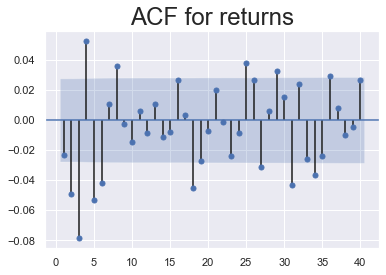

In [54]:
sgt.plot_acf(df['returns'][1:],lags=40,zero=False)
plt.title('ACF for returns', size=24)
plt.show()

In [55]:
## this suggest that we are likely to look at 8 lags

In [44]:
## fitting time-series into a simple moving average model

## MA(1) Returns Model

In [56]:
model_ret_ma_1 = ARMA(df['returns'][1:],order=(0,1))
result_ret_ma_1 = model_ret_ma_1.fit()
result_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 1)   Log Likelihood               -7929.595
Method:                       css-mle   S.D. of innovations              1.174
Date:                Sun, 17 Jan 2021   AIC                          15865.190
Time:                        11:57:59   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.162      0.245      -0.013       0.050
ma.L1.returns    -0.0257      0.015     -1.720      0.085      -0.055       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.8547           +0.0000j           38.8547            0.0000
-----------------------------------------------------------------------------
"""

In [59]:
## coefficients for one lag ago residual is significant at the 10% level but not at the 5% level --- this is shown
## by the acf graph above as the first line is inside the blue band (not sig diffrent than 0)

## however all other coeficents upto 6 lags ago fell outside the blue area which suggest significance

## the 8th and the 18th lag were also signifiacnt -- aslo some other more than 20 periods ago shown by acf graph

# since we expect the compound effect decrese the further back in time we go, thus we can disregard 18th lag and all other
## significant perios that follow it

## beacuse we expect their impact on todays return to be minimal

## also check if we should add 8th lag?? or should we select one of the simpler model??? 

## Higher lag MA model for returns

In [65]:
model_ret_ma_2 = ARMA(df['returns'][1:],order=(0,2))
result_ret_ma_2 = model_ret_ma_2.fit()
print(result_ret_ma_2.summary())

print("LLR test p-value: ", llr_test(model_ret_ma_1,model_ret_ma_2)) ## using print twice because later shadows the former

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 2)   Log Likelihood               -7922.864
Method:                       css-mle   S.D. of innovations              1.173
Date:                Sun, 17 Jan 2021   AIC                          15853.728
Time:                        12:09:35   BIC                          15879.812
Sample:                    01-10-1994   HQIC                         15862.868
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.239      0.215      -0.011       0.049
ma.L1.returns    -0.0327      0.014     -2.297      0.022      -0.061      -0.005
ma.L2.returns    -0.0502      0.014     

In [67]:
## p-value for the error term 2 perids ago is significant , this matches our expectation from the acf curve

## p-value for the error term 1 periods ago is also significant now,, thus we went from having no coeff sig to all coeff
## being significant 

## this is exactly what we were aiming for while fitting the more complex model

## since model2 has sig coeff and model1 has not--- assume: MA(2) is a better FIT than MA(1) but directly assuming 
## such statements is problematic in analysis -- thus we run LLR test which gives p-val of 0 which tell MA(2) makes
## significantly better prediction

### MA(3) model

In [68]:
model_ret_ma_3 = ARMA(df['returns'][1:],order=(0,3))
result_ret_ma_3 = model_ret_ma_3.fit()
print(result_ret_ma_3.summary())

print("LLR test p-value: ", llr_test(model_ret_ma_2,model_ret_ma_3)) 

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 3)   Log Likelihood               -7904.317
Method:                       css-mle   S.D. of innovations              1.168
Date:                Sun, 17 Jan 2021   AIC                          15818.634
Time:                        12:16:18   BIC                          15851.240
Sample:                    01-10-1994   HQIC                         15830.060
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.376      0.169      -0.008       0.046
ma.L1.returns    -0.0203      0.014     -1.423      0.155      -0.048       0.008
ma.L2.returns    -0.0556      0.013     

In [69]:
## the new coeff has p-val of 0 which makes it significant ,, the same can also be said about the second lag but not 
## the first 
## since ACF suggest the first period coeff should not be significant --the correct model will have high p-val for the
## one period ago error term

## lower LLR value suggest MA(3) is better model than it simpler counterpart MA(2)

In [70]:
model_ret_ma_4 = ARMA(df['returns'][1:],order=(0,4))
result_ret_ma_4 = model_ret_ma_4.fit()
print(result_ret_ma_4.summary())

print("LLR test p-value: ", llr_test(model_ret_ma_3,model_ret_ma_4)) 

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 4)   Log Likelihood               -7898.773
Method:                       css-mle   S.D. of innovations              1.167
Date:                Sun, 17 Jan 2021   AIC                          15809.547
Time:                        12:20:39   BIC                          15848.674
Sample:                    01-10-1994   HQIC                         15823.257
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.305      0.192      -0.009       0.047
ma.L1.returns    -0.0203      0.014     -1.443      0.149      -0.048       0.007
ma.L2.returns    -0.0551      0.014     

In [71]:
model_ret_ma_5 = ARMA(df['returns'][1:],order=(0,5))
result_ret_ma_5 = model_ret_ma_5.fit()
print(result_ret_ma_5.summary())

print("LLR test p-value: ", llr_test(model_ret_ma_4,model_ret_ma_5)) 

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 5)   Log Likelihood               -7892.823
Method:                       css-mle   S.D. of innovations              1.166
Date:                Sun, 17 Jan 2021   AIC                          15799.645
Time:                        12:20:59   BIC                          15845.294
Sample:                    01-10-1994   HQIC                         15815.641
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.376      0.169      -0.008       0.046
ma.L1.returns    -0.0262      0.014     -1.851      0.064      -0.054       0.002
ma.L2.returns    -0.0497      0.014     

In [72]:
model_ret_ma_6 = ARMA(df['returns'][1:],order=(0,6))
result_ret_ma_6 = model_ret_ma_6.fit()
print(result_ret_ma_6.summary())

print("LLR test p-value: ", llr_test(model_ret_ma_5,model_ret_ma_6)) 

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 6)   Log Likelihood               -7889.221
Method:                       css-mle   S.D. of innovations              1.165
Date:                Sun, 17 Jan 2021   AIC                          15794.442
Time:                        12:21:19   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.430      0.153      -0.007       0.045
ma.L1.returns    -0.0237      0.014     -1.682      0.093      -0.051       0.004
ma.L2.returns    -0.0486      0.014     

In [74]:
model_ret_ma_7 = ARMA(df['returns'][1:],order=(0,7))
result_ret_ma_7 = model_ret_ma_7.fit()
print(result_ret_ma_7.summary())

print("LLR test p-value: ", llr_test(model_ret_ma_6,model_ret_ma_7)) 

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 7)   Log Likelihood               -7889.046
Method:                       css-mle   S.D. of innovations              1.165
Date:                Sun, 17 Jan 2021   AIC                          15796.091
Time:                        12:22:09   BIC                          15854.782
Sample:                    01-10-1994   HQIC                         15816.657
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.418      0.156      -0.007       0.045
ma.L1.returns    -0.0247      0.014     -1.739      0.082      -0.052       0.003
ma.L2.returns    -0.0488      0.014     

In [76]:
## p-value for LLR test is not significant not are the p-values of coeff of 7th lag significant
## thus model MA(7) is not better than MA(6) -- thus we go for model MA(6) instead

In [77]:
## ACF plot shows than MA(8) was significant let's check it!!

In [78]:
model_ret_ma_8 = ARMA(df['returns'][1:],order=(0,8))
result_ret_ma_8 = model_ret_ma_8.fit()
print(result_ret_ma_8.summary())

print("LLR test p-value: ", llr_test(model_ret_ma_7,model_ret_ma_8)) 

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood               -7885.603
Method:                       css-mle   S.D. of innovations              1.164
Date:                Sun, 17 Jan 2021   AIC                          15791.205
Time:                        12:25:32   BIC                          15856.417
Sample:                    01-10-1994   HQIC                         15814.056
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.364      0.173      -0.008       0.046
ma.L1.returns    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.returns    -0.0495      0.014     

In [80]:
## indeed the coeff of 8th lag is significant 
## also the p-value for LLR test is significant -- thus better model than MA(7)

## MA(8) is better predictor than MA(7)

In [81]:
## let us check if MA(8) is better approximation than the simpler MA(6)

In [83]:
llr_test(model_ret_ma_6,model_ret_ma_8,df=2)

## we need to estimate the coefficients for the 8 variables in the complicated model MA(8) which is 2 more than the 
## 6 from the MA(6) model

0.027

In [84]:
## this is less than 0.05 , thus the more complicated model performs better than the simpler one even though it cotains
## an additonal non-signinficant coefficeints 

## from ACF none of the 9 coeff after 8th lag is significant, thus adding them should not improve the model sufficiently


In [85]:
## we have now selected the model based on ACF and the summariezed statistics 

### Residuals for Returns

In [86]:
## from ma(8) model which was better approximation

In [93]:
df['res_ret_ma_8'] = result_ret_ma_8.resid[1:]
print('mean of the residuals',round(df['res_ret_ma_8'].mean(),3))
print('variance of the residuals',round(df['res_ret_ma_8'].var(),3))
print('standard deviation of residuals', round(sqrt(df['res_ret_ma_8'].var()),3))

mean of the residuals -0.0
variance of the residuals 1.356
standard deviation of residuals 1.164


<ipython-input-93-66978437a1a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ret_ma_8'] = result_ret_ma_8.resid[1:]


In [90]:
## mean is close to 0 and has low varinace:: thus can asusme stationary data

In [95]:
## we expect most return residuals will be between (-3.5 , 3.5) 3*1.164 = 3.5 (99.7)

## in worst case scenario, we could be upto 3.5*2 = 7% point off when predicting the retunrs for the market index
## 7%=[-3.5,3.5],, since we are examining the error terms not the returns ,, but 7% can make all difference we it come
## to profit and losses

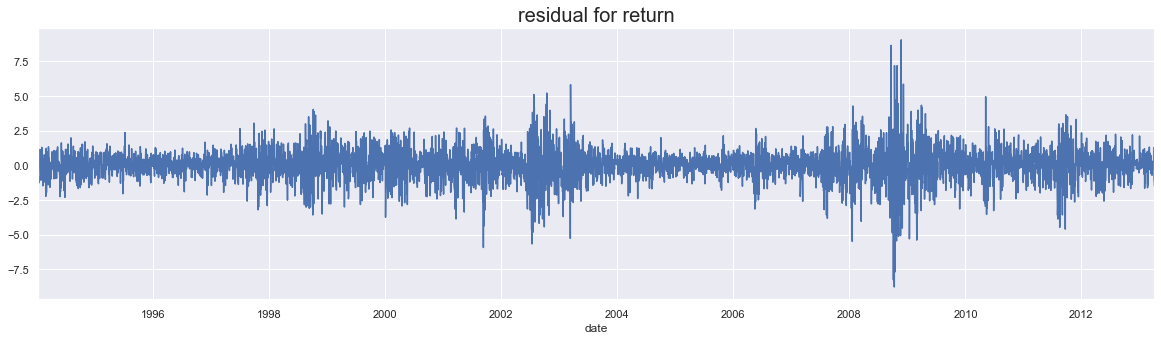

In [96]:
## let us plot the graph and see

df['res_ret_ma_8'][1:].plot(figsize=(20,5))
plt.title('residual for return',size=20)
plt.show()

In [97]:
## if we exlude the .com and housing price bubbles in 90's and 2000's and the crisis following them then the residuals
## are rather random -- confined within reasonable range which can be expected 

In [98]:
## to test if the residual resemble white noise process we can check for stationarity 

## if non-statinarity -- cannnot be a whtie noise

In [100]:
sts.adfuller(df['res_ret_ma_8'][2:])

(-70.83581021411266,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 15684.052185516364)

In [101]:
## the p-value is 0, so it is indeed stationary 

In [102]:
## but stationarity is not the same as white noise so we should also examine the ACF for residuals


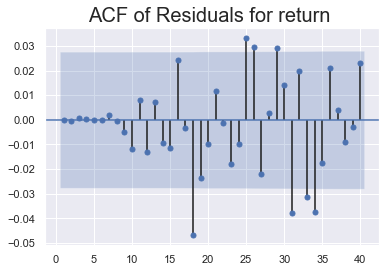

In [103]:
sgt.plot_acf(df['res_ret_ma_8'][2:],lags=40,zero=False)
plt.title('ACF of Residuals for return ',size=20)
plt.show()

In [104]:
## most coeff are not-significant ,, none of the first 17 lags are significant 
## first 8 of them is incorporated into the model -- not surprising they are close to 0
## remaining 9 lags follwing them is also not-significant 
##t his is the estimate of how well our model performs ,, the further back in time we go the less relevant the value
## and the error becomes 

##hence significant coeff some 18 lags ago should not paly a major role in estimation

## market ajust to shocks so values far in the past lose relevance 

In [105]:
## analyzing the residual for MA(6) model:

In [106]:
df['res_ret_ma_6'] = result_ret_ma_6.resid[1:]
print('mean of the residuals',round(df['res_ret_ma_6'].mean(),3))
print('variance of the residuals',round(df['res_ret_ma_6'].var(),3))
print('standard deviation of residuals', round(sqrt(df['res_ret_ma_6'].var()),3))

mean of the residuals -0.0
variance of the residuals 1.357
standard deviation of residuals 1.165


<ipython-input-106-633b4335681f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ret_ma_6'] = result_ret_ma_6.resid[1:]


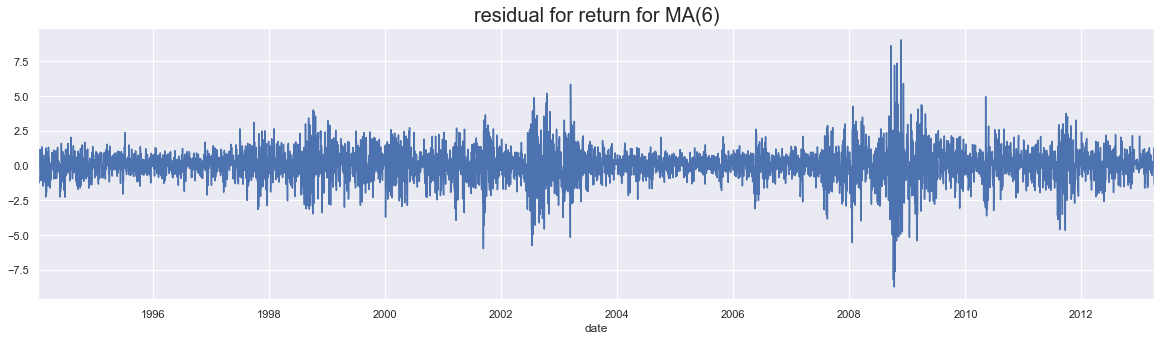

In [108]:
## let us plot the graph and see

df['res_ret_ma_6'][1:].plot(figsize=(20,5))
plt.title('residual for return for MA(6)',size=20)
plt.show()

In [109]:
## to test if the residual resemble white noise
sts.adfuller(df['res_ret_ma_6'][2:])

(-70.83995760325327,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 15691.135289710657)

In [110]:
## the p-value is 0, so it is indeed stationary 

In [111]:
## but stationarity is not the same as white noise so we should also examine the ACF for residuals


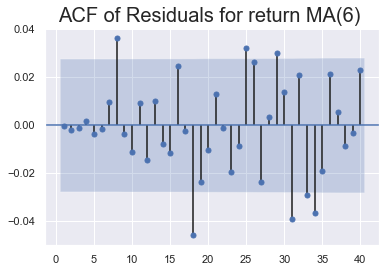

In [112]:
sgt.plot_acf(df['res_ret_ma_6'][2:],lags=40,zero=False)
plt.title('ACF of Residuals for return MA(6) ',size=20)
plt.show()

### Normalized Returns

In [113]:
## since we might be comapring different market index ,, normalizing is cruical

In [114]:
bench_ret = df['return'].iloc[1]

In [118]:
df.returns[1]

-0.1567043337454055

In [121]:
df['norm_ret'] = df['return'].div(bench_ret).mul(100)
df.head()

<ipython-input-121-ff96a0515067>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_ret'] = df['return'].div(bench_ret).mul(100)


,market_value,return,returns,res_ret_ma_8,res_ret_ma_6,norm_ret
date,,,,,,
1994-01-07,3445.98,NaN,NaN,NaN,NaN,NaN
1994-01-10,3440.58,-0.156704,-0.156704,NaN,NaN,100.000000
1994-01-11,3413.77,-0.779229,-0.779229,-0.802111,-0.802083,497.260711
1994-01-12,3372.02,-1.222988,-1.222988,-1.269464,-1.268789,780.443046
1994-01-13,3360.01,-0.356166,-0.356166,-0.464780,-0.461319,227.285567


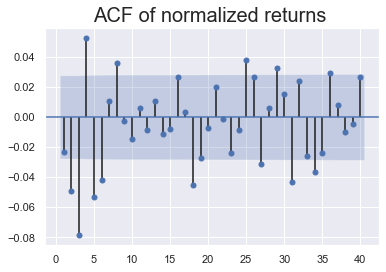

In [122]:
sgt.plot_acf(df['norm_ret'][1:],zero=False,lags=40)
plt.title('ACF of normalized returns ',size=20)
plt.show()

In [124]:
## similar to the one we got for non-normalized value
## by obeserving which point fall outside the blue area we get an idea of which lag to include-- graph suggest using
## ma(6) or ma(8) model again!!

In [125]:
## let us fit set the model and examine their coeff

In [126]:
## lets start with MA(8)

In [127]:
model_norm_ret_ma_8 = ARMA(df['norm_ret'][1:],order=(0,8))
results_norm_ret_ma_8 = model_norm_ret_ma_8.fit()
results_norm_ret_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood              -40307.597
Method:                       css-mle   S.D. of innovations            742.822
Date:                Sun, 17 Jan 2021   AIC                          80635.194
Time:                        13:45:43   BIC                          80700.406
Sample:                    01-10-1994   HQIC                         80658.045
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731      8.846     -1.354      0.176     -29.311       5.364
ma.L1.norm_ret    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.norm_ret    -0.0495      0.014     -3.514      0.000      -0.077      -0.022
ma.L3.norm_ret    -0.0847      0.014     -5.993      0.000      -0.112      -0.057
ma.L4.norm_ret     0.0488      0.014      3.440      0.001       0.021       0.077
ma.L5.norm_ret    -0.0518      0.014     -3.634      0.000      -0.080      -0.024
ma.L6.norm_ret    -0.0402      0.014     -2.787      0.005      -0.068      -0.012
ma.L7.norm_ret     0.0084      0.014      0.587      0.557      -0.020       0.036
ma.L8.norm_ret     0.0366      0.014      2.626      0.009       0.009       0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.4716           -0.4282j            1.5326           -0.0451
MA.2            1.4716           +0.4282j            1.5326            0.0451
MA.3            0.5944           -1.3169j            1.4448           -0.1825
MA.4            0.5944           +1.3169j            1.4448            0.1825
MA.5           -0.7318           -1.2736j            1.4689           -0.3330
MA.6           -0.7318           +1.2736j            1.4689            0.3330
MA.7           -1.4485           -0.6983j            1.6081           -0.4285
MA.8           -1.4485           +0.6983j            1.6081            0.4285
-----------------------------------------------------------------------------
"""

In [128]:
### same as the non-normalized one -- thus normalizing the input data has no effect on model selection

In [129]:
## let us examine residual to see MA(8) is the correct model for this case:


In [130]:
df['res_norm_ret_ma_8'] = results_norm_ret_ma_8.resid[1:]

<ipython-input-130-aa92fbf1a11d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_norm_ret_ma_8'] = results_norm_ret_ma_8.resid[1:]


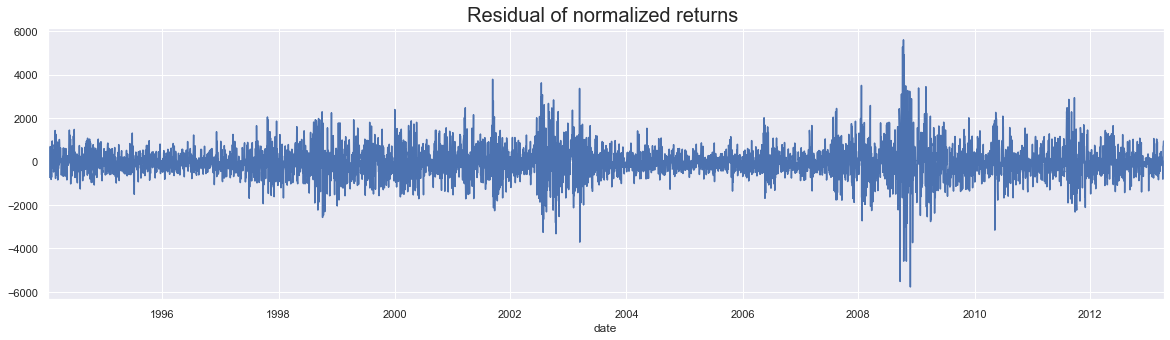

In [131]:
df['res_norm_ret_ma_8'].plot(figsize=(20,5))
plt.title("Residual of normalized returns ",size=20)
plt.show()

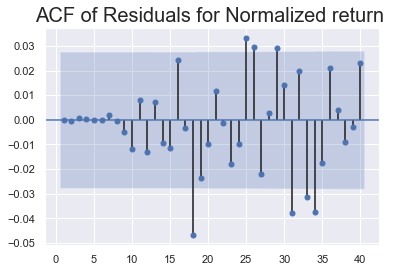

In [132]:
sgt.plot_acf(df['res_norm_ret_ma_8'][2:],lags=40,zero=False)
plt.title("ACF of Residuals for Normalized return ",size=20)
plt.show()


In [133]:
## The ACF suggest tha the residuals resemble white noise -- thus our model code is supposedly correct

In [134]:
### lET us see for MA(6) normalized residualaa

In [135]:
model_norm_ret_ma_6 = ARMA(df['norm_ret'][1:],order=(0,6))
results_norm_ret_ma_6 = model_norm_ret_ma_6.fit()
results_norm_ret_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(0, 6)   Log Likelihood              -40311.216
Method:                       css-mle   S.D. of innovations            743.358
Date:                Sun, 17 Jan 2021   AIC                          80638.431
Time:                        13:53:02   BIC                          80690.601
Sample:                    01-10-1994   HQIC                         80656.712
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731      8.442     -1.418      0.156     -28.519       4.572
ma.L1.norm_ret    -0.0237      0.014     -1.682      0.093      -0.051       0.004
ma.L2.norm_ret    -0.0486      0.014     -3.436      0.001      -0.076      -0.021
ma.L3.norm_ret    -0.0827      0.014     -5.846      0.000      -0.110      -0.055
ma.L4.norm_ret     0.0466      0.014      3.434      0.001       0.020       0.073
ma.L5.norm_ret    -0.0484      0.014     -3.370      0.001      -0.077      -0.020
ma.L6.norm_ret    -0.0387      0.014     -2.682      0.007      -0.067      -0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.5011           -0.0000j            1.5011           -0.0000
MA.2            0.8248           -1.4775j            1.6921           -0.1690
MA.3            0.8248           +1.4775j            1.6921            0.1690
MA.4           -1.0066           -1.2260j            1.5863           -0.3594
MA.5           -1.0066           +1.2260j            1.5863            0.3594
MA.6           -2.3890           -0.0000j            2.3890           -0.5000
-----------------------------------------------------------------------------
"""

In [137]:
df['res_norm_ret_ma_6'] = results_norm_ret_ma_6.resid[1:]

<ipython-input-137-781ad46dd48a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_norm_ret_ma_6'] = results_norm_ret_ma_6.resid[1:]


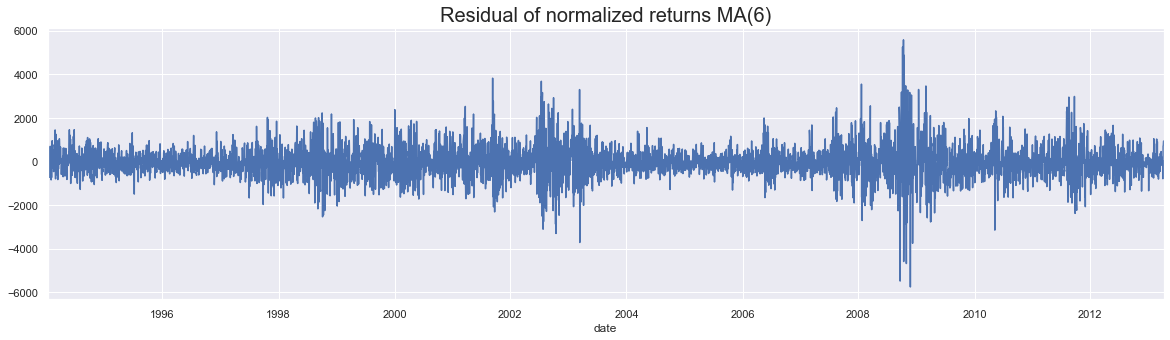

In [138]:
df['res_norm_ret_ma_6'].plot(figsize=(20,5))
plt.title("Residual of normalized returns MA(6)",size=20)
plt.show()

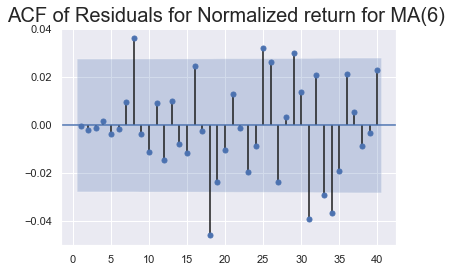

In [139]:
sgt.plot_acf(df['res_norm_ret_ma_6'][2:],lags=40,zero=False)
plt.title("ACF of Residuals for Normalized return for MA(6) ",size=20)
plt.show()


In [140]:
## if both model are similar make sure to conduct ## LLR test to claim the suppot of choosing the more complex model

## MA model for Non-Stationarity Data

### MA model for prices

In [142]:
## to get the idea of how many lags to include in our model -- let's use ACF 

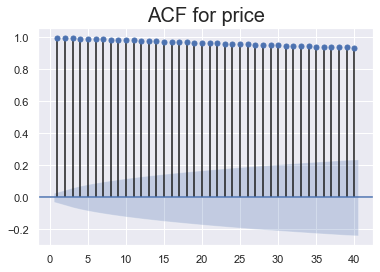

In [145]:
sgt.plot_acf(df['market_value'],lags=40,zero=False)
plt.title('ACF for price',size=20)
plt.show()

In [146]:
## this suggest that price data is highly autocorrelated ,, 
## coeff for all 40 lags seems to be significant 
## this suggest any higher lagged model would be preferred than lower 

## this suggest we should have to use infinite-MA model to fit the data MA(INFINITE)
## since no such things exist it seems no moving average model would be a good estimator of prices 

In [147]:
## but before discrediting this result,, let us fit several MA model for prices and examine their result 

In [148]:
model_ma_1 = ARMA(df['market_value'],order=(0,1))
result_ma_1 = model_ma_1.fit()
result_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(0, 1)   Log Likelihood              -38629.000
Method:                       css-mle   S.D. of innovations            530.756
Date:                Sun, 17 Jan 2021   AIC                          77264.000
Time:                        14:03:25   BIC                          77283.564
Sample:                    01-07-1994   HQIC                         77270.856
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.4929     14.660    347.180      0.000    5060.761    5118.225
ma.L1.market_value     0.9573      0.003    335.548      0.000       0.952       0.963
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0446           +0.0000j            1.0446            0.5000
-----------------------------------------------------------------------------
"""

In [149]:
## both the constant and MA1 coefficients are signifiacnt and one-lag coeff is 0.9573 which is close to 1

## our model tries to keep almost the entire magnitude of the error term from the last period i.e each time a model
## tries to predict a value it tries to maximize on the error from the last time ,, since this is simple model eith 
## only 1 lag the error term contains all the information from the other lags 

## our model has established that this model is truly valueable and tries to use it


In [150]:
## MA model do not perfrom well for non-stationary data

In [ ]:
### Residuals did not fully resembled white noise
## thus neither AR and MA model is sufficient to predict price returns 